## Implementation Setup

In [6]:
import pandas as pd
import numpy as np

import matplotlib.image as img
import matplotlib.pyplot as plt

import cv2 as cv
import imutils
import pytesseract
from imutils.contours import sort_contours
import argparse
import random
import traceback

In [2]:
## CREATING DICTIONNARY ASSOCIATING IMAGE FILENAME W/ IMAGE CONTENT
import os
d = dict()
size = 0
with open('ascii/words.txt','r') as f:
    for line in f.readlines():
        if line[0] != '#' and line.split()[1] == "ok":
            size += 1
            if size > 5000:
                break
            l = line.split()
            d[l[0]] = l[-1]

# EXAMPLE
print("Content of file a01-000u-00-00: ", d["a01-000u-00-00"])

Content of file a01-000u-00-00:  A


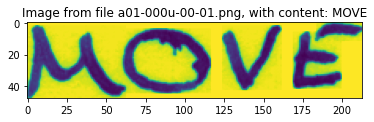

In [3]:
## PLOT OF IMAGE FROM DATASET
image = img.imread("./words/a01/a01-000u/a01-000u-00-01.png", 0)
plt.imshow(image)
plt.title(f'Image from file a01-000u-00-01.png, with content: {d["a01-000u-00-01"]}')
plt.show()

In [7]:
## FETCHING ALL THE DATASET
images = []         #list of all the images in the same order as paths
paths = []          #list of all the paths in order
shapes = [[], []]
for name in d.keys():
    path = "./words/"
    directories = name.split('-')
    path += directories[0] + "/"
    path += directories[0] + "-" + directories[1] + "/"
    path += name + ".png"
    paths.append(path)
    try:
        image = img.imread(path)
        images.append([image, d[name]])
        shapes[0].append(image.shape[0])
        shapes[1].append(image.shape[1])
        # LOOKING FOR PARTICULAR IMAGE
        #if image.shape[0] == 60:
            #plt.imshow(image)
    except:
        SyntaxError
images = np.array(images, dtype=object)
paths  = np.array(paths,  dtype=object)

## Helper Functions

In [16]:
def find_min_diff(num, array):
    """Finds the minimum difference between a value and every value of an array"""
    diff = []
    for el in array:
        diff.append(abs(num - el))
        
    if len(diff) == 0:
        return min_separation_threshold + 1
    return min(diff)

In [15]:
def get_low_points(array):
    """Returns low points from the image, determined depending on lp
    which is the maximum between the first and last column's number of 
    max pixels (==255) + a threshold for errors (8)"""
    low = [0]
    lp = max(array[0], array[-1]) + 8
    for i in range(1, len(array)):
        el = array[i]
        if el < lp and ( i - low[-1] > 30 ):
            low.append(i)
    return low

## Image Modification Functions

In [10]:
def fitToSize(thresh1):
    """Crops the image so that it is readable by our algorithm
    NoT sUpEr NeCeSsArY
    returns: cropped image"""
    
    mask = thresh1 > 0
    coords = np.argwhere(mask)

    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    cropped = thresh1[x0:x1,y0:y1]
    return cropped

In [23]:
def prepareImage(img):
    """Changes the image into a 255 pixel based image"""
    img = img.astype("float32")
    img *= 255
    img = img.astype("uint8")
    return img

In [11]:
def findCapPoints(img):
    """Finds Cap points, i.e cpoints (resp. dpoints) is a list for each columns that returns the 
    coordinates of the first pixel == 255 starting from the top (resp. bottom)"""
    cpoints=[]
    dpoints=[]
    for i in range(img.shape[1]):
        col = img[:,i:i+1]
        k = col.shape[0]
        while k > 0:
            if col[k-1]==255:
                dpoints.append((i,k))
                break
            k-=1
        
        for j in range(col.shape[0]):
            if col[j]==255:
                cpoints.append((i,j))
                break
    return cpoints,dpoints

In [54]:
def baselines(h, w, letter2, upoints, dpoints, letterGray):
    """Baselines is a function that returns the upper line and lower line
    that need to be taken into account so as to focus on the pixels that are between
    them, in order to reduce the noise in the datapoints.
    In order to do this, baselines uses the arrays containing the cap points
    defined above."""
##-------------------------Creating upper baseline-------------------------------##
    colu = []
    for i in range(len(upoints)):
        colu.append(upoints[i][1])
    
    maxyu = max(colu)
    minyu = min(colu)
    avgu = (maxyu + minyu) // 2
    meanu = np.around(np.mean(colu)).astype(int)
    print('Upper:: Max, min, avg, mean:: ',maxyu, minyu, avgu, meanu)
    
##-------------------------------------------------------------------------------##
##-------------------------Creating lower baseline process 1--------------------------##
    cold = []
    for i in range(len(dpoints)):
        cold.append(dpoints[i][1])
    
    maxyd = max(cold)
    minyd = min(cold)
    avgd = (maxyd + minyd) // 2
    meand = np.around(np.mean(cold)).astype(int)
    print('Lower:: Max, min, avg, mean:: ',maxyd, minyd, avgd, meand)
    
##-------------------------------------------------------------------------------##
##-------------------------Creating lower baseline process 2---------------------------##
    cn = []
    count = 0

    for i in range(h):
        for j in range(w):
            if(letterGray[i,j] == 255):
                count+=1
        if(count != 0):
            cn.append(count)
            count = 0    
    maxindex = cn.index(max(cn))
    print('Max pixels at: ',maxindex)
    
##------------------Printing upper and lower baselines-----------------------------##
    
    cv.line(letter2,(0,meanu),(w,meanu),(255,0,0),2)
    lb = 0
    if(maxindex > meand):
        lb = maxindex
        cv.line(letter2,(0,maxindex),(w,maxindex),(255,0,0),2)
    else:
        lb = meand
        cv.line(letter2,(0,meand),(w,meand),(255,0,0),2)
        
    plt.imshow(letter2)
    plt.show()
    return meanu, lb

In [63]:
def histogram(h, w, letter2, upper_baseline, lower_baseline,
             min_separation_threshold):
    """Histogram is a function that:
        -plots the histogram of the number of max pixels (==255)
        per column
        -plots the function that fits this histogram the best in order to 
        get the local minimas needed for the segmentation (stored in f_min)
        -calculates the location of columns that have a low number of 
        max pixels (stored in low_points)
        -returns: the data for each column (colcnt), f_min, low_points,
        and the combination of f_min and low_points within a threshold (min_tot)"""
    ##------------Making Histograms (Default)------------------------######
    cropped = letter2[upper_baseline:lower_baseline,0:w]
    plt.imshow(cropped)
    plt.show()
    colcnt = np.sum(cropped==255, axis=0)
    x = list(range(len(colcnt)))
    plt.plot(colcnt)
    plt.fill_between(x, colcnt, 1, facecolor='blue', alpha=0.5)
    plt.show()
    
    #Getting local minimas of the datapoints
    colcnt_min = np.where((colcnt[1:-1] < colcnt[0:-2]) * (colcnt[1:-1] < colcnt[2:]))[0] + 1
    low_points = get_low_points(colcnt)
    
    pre_min_tot = list(colcnt_min.copy())
    for el in low_points:
        if el not in colcnt_min and ( find_min_diff(el, colcnt_min) > min_separation_threshold ):
            pre_min_tot.append(el)
    pre_min_tot = sorted(pre_min_tot)
    
    z = np.polyfit(x, colcnt, len(pre_min_tot)-1)
    f = np.poly1d(z)
    plt.plot(x, f(x))
    plt.show()
    
    f_min = np.where((f(x)[1:-1] < f(x)[0:-2]) * (f(x)[1:-1] < f(x)[2:]))[0] + 1
    f_min = np.insert(f_min, 0, 0)
    f_min = np.delete(f_min, np.argwhere(np.ediff1d(f_min) <= min_separation_threshold) + 1)
    
    min_tot = list(f_min.copy())
    for el in low_points:
        if el not in f_min and ( find_min_diff(el, f_min) > min_separation_threshold ):
            min_tot.append(el)
    min_tot = sorted(min_tot)
    
    return colcnt, f_min, low_points, min_tot

In [74]:
def visualize(h, w, letter2, upper_baseline, lower_baseline, min_separation_threshold, 
              min_round_letter_threshold, min_tot, letterGray, colcnt):
    """This function returns the columns where the segmentation needs to take place (seg contains
    the indices of the columns that need to be cut).
    The columns that need to be cut are almost always in min_tot, but here we verify that 
    it takes into account round letters, so that it doesn't cut them in half.
    The function also makes a visual plot by drawing a line at those columns"""
    
    seg = [0]
    
    seg1 = min_tot.copy()
    
    ## MODIFIED SEGMENTATION FOR REMOVING CIRCLES          
    arr=[]
    for i in (seg1):
        arr1 = []
        j = upper_baseline
        while(j <= lower_baseline):
            if(letterGray[j,i] == 255):
                arr1.append(1)
            else:
                arr1.append(0)
            j+=1
        arr.append(arr1)
    print('Seg1 is = ', seg1)
    
    ones = []
    for i in (arr):
        ones1 = []
        for j in range(len(i)):
            if (i[j] == 1):
                ones1.append([j])
        ones.append(ones1)
        
    diffarr = []
    for i in (ones):
        if len(i) == 0:
            diff = 0
        else:
            diff = i[-1][0] - i[0][0]
        diffarr.append(diff)
    print('Difference array: ',diffarr)
    
    for i in range(len(seg1)):
        if(diffarr[i] < min_round_letter_threshold):
            seg.append(seg1[i])
            
    ## CHECK FOR LAST ELEMENT SPACING
    if len(colcnt) - 1 - seg[-1] <= min_separation_threshold:
        seg[-1] = len(colcnt) - 1
    print("seg = ", seg)
    
    
    ## MAKE THE CUT
    letter3 = cv.line(letter2,(seg[0],0),(seg[0],h),(255,0,0),2)
    for i in range(1, len(seg)):
        letter3 = cv.line(letter2,(seg[i],0),(seg[i],h),(255,0,0),2)
    
    print("Does it work::::")
    plt.imshow(letter3)
    plt.show()
    return seg 

## Segmenting Words

In [81]:
def segmentCharacters(seg,lettergray, fn):
    """This function is the function that actually cuts the image at the given 
    columns in seg.
    It returns a list of arrays containing the image information of each letter,
    and it also plots each image accordingly."""
    s=0
    wordImgList = []
    for i in range(len(seg)):
        if i==0:
            s=seg[i]
            if s > 15:
                wordImg = lettergray[0:,0:s]
                cntx=np.count_nonzero(wordImg == 255) 
                print ('count',cntx)
                plt.imshow(wordImg)
                plt.show()
                fn=fn+1
            else:
                continue
        else:
            if seg[i]-s > 15:
                wordImg = lettergray[0:,s:seg[i]]
                cntx=np.count_nonzero(wordImg == 255) 
                print ('count',cntx)
                plt.imshow(wordImg)
                plt.show()
                fn=fn+1
                s=seg[i]
            else:
                continue
        wordImgList.append(wordImg)

    return wordImgList

In [82]:
def MakeSegmentation(img):
    """Segments the Words in input, returns the letters found in the word"""
    og_img = prepareImage(img)
    print ('Image shape: ',og_img.shape)

    fn = 0
    counter = 0
    
    ###CONTRAST AND CROP IMAGE
    th, img = cv.threshold(og_img, 250, 255, cv.THRESH_BINARY_INV|cv.THRESH_OTSU)
    img = fitToSize(img)
    letter2 = img.copy()
    img = cv.dilate(img,None,iterations = 4)
    
    ##FIND CAP POINTS, AND BASELINES (IGNORE ALL POINTS ABOVE UBL AND BELOW LBL)
    h = img.shape[0]
    w = img.shape[1]
    
    upoints, dpoints=findCapPoints(img)
    upper_baseline, lower_baseline = baselines(h, w, letter2, upoints, dpoints, img) # UBL, LBL

    ## TUNING PARAMETERS
    min_separation_threshold = 30          #Lowerbound to the number of pixels two cuts need to be appart
    min_round_letter_threshold = 190       #Round letter threshold
    
    ##MAKE HISTOGRAM OF NUMBER OF COLUMN MAX PIXELS, PLOT THE FITTED CURVE OF THE HISTOGRAM
    ## AND RETURN THE LOCAL MINIMAS AND LOW POINTS FOR BETTER SEGMENTATION
    colcnt, f_min, low_points, min_tot = histogram(h, w, letter2, upper_baseline, lower_baseline,
                                                  min_separation_threshold)
    
    ##TUNING PARAMETERS 2
    min_pixel_threshold = colcnt.min() + 3 #Upperbound of the max pixel intensity we want our seg columns to have

    ##VISUALIZE THE SEGMENTATION AND GET SEG COLUMNS
    seg = visualize(h, w, letter2, upper_baseline, lower_baseline, min_separation_threshold, 
              min_round_letter_threshold, min_tot, img, colcnt)
    
    ##SEGMENT THE CHARACTERS AND GET THE IMAGES OF CHARACTERS
    CharImgList = segmentCharacters(seg, og_img, fn)
    for i in CharImgList:
        cv.imwrite("./result/characters/" + str(counter) +".jpeg",i)
        counter=counter+1
    
    return CharImgList

## Testing on Random Image

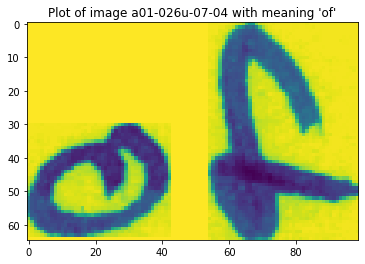

In [86]:
i = random.randint(0, len(images))
img = images[i][0]
path = paths[i]
path_split = path.split('/')[4]
path_split = path_split.split('.')[0]
plt.imshow(img)
plt.title(f"Plot of image {path_split} with meaning '{d[path_split]}'")
plt.show()

Image shape:  (65, 99)
Upper:: Max, min, avg, mean::  43 0 21 21
Lower:: Max, min, avg, mean::  65 50 57 62
Max pixels at:  43


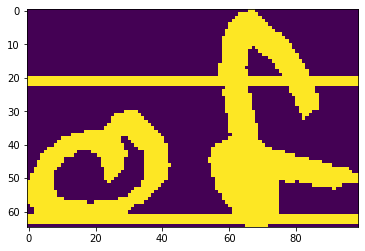

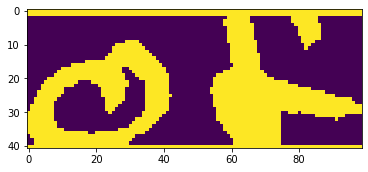

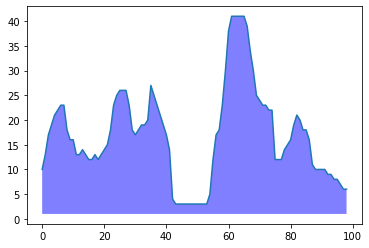

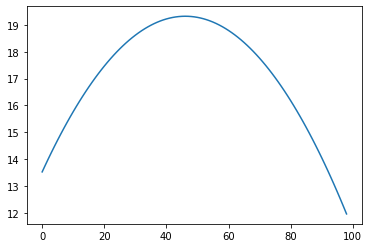

Seg1 is =  [0, 40, 75]
Difference array:  [23, 29, 41]
seg =  [0, 0, 40, 98]
Does it work::::


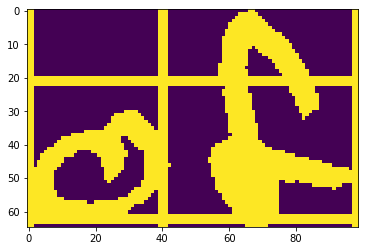

count 1240


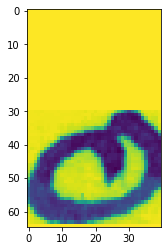

count 808


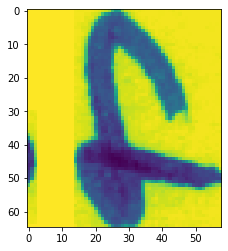

In [87]:
CharImgList = MakeSegmentation(img)